# Message passing neural network for segment classification on 2D toy data

In this notebook we'll implement a model similar to the Interaction Networks model:
https://arxiv.org/abs/1612.00222

The model will consider a graph of connected hits and try to determine which edges are real and which are spurious.

In [1]:
import os

# Training concurrency
os.environ['OMP_NUM_THREADS'] = '6'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

cuda = True

In [2]:
# System imports
from __future__ import print_function
from timeit import default_timer as timer

# Externals
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics

# Torch imports
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

# Local imports
from estimator import Estimator

%matplotlib notebook

## Data utilities

In [3]:
def gen_tracks(n, det_r):
    """
    Generate n straight tracks.
    
    Returns array of hit coordinates for each track with shape:
    (n, num_det_layers)
    """
    xin = np.random.uniform(size=n).astype(np.float32)
    xout = np.random.uniform(size=n).astype(np.float32)
    slopes = (xout - xin) / (det_r[-1] - det_r[0])
    x = np.outer(slopes, det_r) + xin[:,None]
    return x

def generate_data(n_events, n_tracks, det_r, sort_first_labels=False):
    n_det_layers = det_r.shape[0]

    # Generate all the tracks we'll need
    tracks = np.stack([gen_tracks(n_events, det_r)
                       for i in range(n_tracks)], axis=1)

    idx0 = np.arange(n_events)[:, None, None]
    idx2 = np.arange(n_det_layers)[None, None, :]

    if sort_first_labels:
        # Sort according to the first hit position, so the labels are
        # consistently defined in terms of the first layer hit order.
        # Note: singleton ('None') idx axes indicate a repeat-broadcast.
        idx1 = tracks[:, :, 0].argsort(axis=1)[:, :, None]
        tracks = tracks[[idx0, idx1, idx2]]

    # Now sort all hits on all layers by their position.
    # This sort index relative to previous sort gives us our hit labels.
    idx = np.argsort(tracks, axis=1)
    x = tracks[[idx0, idx, idx2]]

    # Transpose to shape (n_event, n_layer, n_hit)
    return x.transpose([0,2,1]), idx.transpose([0,2,1])

In [4]:
if cuda:
    np_to_torch = lambda x, volatile=False: (
        Variable(torch.from_numpy(x.astype(np.float32)), volatile=volatile).cuda())
else:
    np_to_torch = lambda x, volatile=False: (
        Variable(torch.from_numpy(x.astype(np.float32)), volatile=volatile))

torch_to_np = lambda x: x.cpu().data.numpy()

## Generate a toy dataset

In [5]:
# Data config
det_r = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=np.float)
n_det_layers = det_r.shape[0]
n_events = 2**15
n_tracks = 4

In [6]:
# Hit position and label
hits_x, hits_y = generate_data(n_events, n_tracks, det_r)
# Hit radius
hits_r = np.broadcast_to(det_r[None, :, None], hits_x.shape)
# Layer number
hits_l = np.broadcast_to(np.arange(n_det_layers)[None, :, None], hits_x.shape)
print(hits_x.shape, hits_y.shape)

# Flattened arrays
x, y, r, l = [a.reshape((n_events, -1)) for a in [hits_x, hits_y, hits_r, hits_l]]
print(list(map(np.shape, [x, y, r, l])))

(32768, 10, 4) (32768, 10, 4)
[(32768, 40), (32768, 40), (32768, 40), (32768, 40)]


<IPython.core.display.Javascript object>


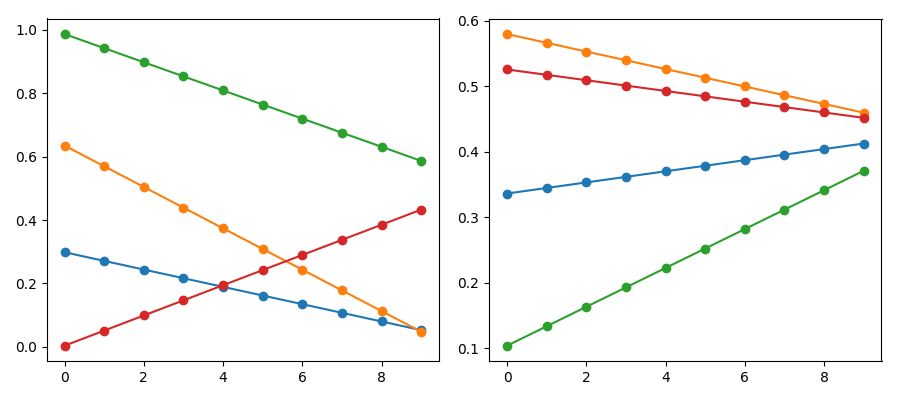

In [7]:
plt.figure(figsize=(9,4))
plt.subplot(121)
i = 0
for yy in np.unique(y[i]):
    idx = (y[i] == yy)
    plt.plot(r[i, idx], x[i, idx], 'o-')

plt.subplot(122)
i = 1
for yy in np.unique(y[i]):
    idx = (y[i] == yy)
    plt.plot(r[i, idx], x[i, idx], 'o-')

plt.tight_layout()

## Build graph representation

To specify the graph, we need to
- enumerate the edges
- construct binary matrices that associate hits onto edges

We separate out the outgoing edges from incoming edges with two matrices: $\bf R_o$ and $\bf R_i$.

In [8]:
%%time

n_hits = n_tracks * n_det_layers
n_edges = n_tracks**2 * (n_det_layers - 1)

# Now we take advantage of the fact that all of the
# toy events have the same association matrices.
d = l[0,None,:] - l[0,:,None]
e = np.stack(np.where(d==1), axis=1)
Ri = np.zeros((1, n_hits, n_edges), dtype=np.uint16)
Ro = np.zeros((1, n_hits, n_edges), dtype=np.uint16)
Ri[:, e[:,1], np.arange(n_edges)] = 1
Ro[:, e[:,0], np.arange(n_edges)] = 1

Ri = Ri.repeat(n_events, axis=0)
Ro = Ro.repeat(n_events, axis=0)

CPU times: user 20 ms, sys: 100 ms, total: 120 ms
Wall time: 122 ms


In [9]:
# Node features tensor with shape: (events, hits, features)
X = np.stack([x, r], axis=-1)

# Compute edge labels
yo = np.matmul(y[:,None], Ro).squeeze(1)
yi = np.matmul(y[:,None], Ri).squeeze(1)
ey = (yi == yo)

## Define the model

In [10]:
class EdgeNetwork(nn.Module):
    """
    A module which computes weights for edges of the graph.
    For each edge, it selects the associated nodes' features
    and applies some fully-connected network layers with a final
    sigmoid activation.
    """
    def __init__(self, input_dim, hidden_dim=8, hidden_activation=nn.Tanh):
        super(EdgeNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim*2, hidden_dim),
            hidden_activation(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid())
    def forward(self, X, Ri, Ro):
        # Select the features of the associated nodes
        bo = torch.matmul(Ro.transpose(1, 2), X)
        bi = torch.matmul(Ri.transpose(1, 2), X)
        B = torch.cat([bo, bi], dim=2)
        # Apply the network to each edge
        return self.network(B).squeeze(-1)

class NodeNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, output_dim, hidden_activation=nn.Tanh):
        super(NodeNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim*3, output_dim),
            hidden_activation(),
            nn.Linear(output_dim, output_dim),
            hidden_activation())
    def forward(self, X, e, Ri, Ro):
        bo = torch.matmul(Ro.transpose(1, 2), X)
        bi = torch.matmul(Ri.transpose(1, 2), X)
        Rwo = Ro * e[:,None]
        Rwi = Ri * e[:,None]
        mi = torch.matmul(Rwi, bo)
        mo = torch.matmul(Rwo, bi)
        M = torch.cat([mi, mo, X], dim=2)
        return self.network(M)

class SegmentClassifier(nn.Module):
    """
    A graph neural network for classifying edges (track segments).
    The model first applies a transformation to each node's features.
    Then, it alternates application of edge and node networks.
    The edge networks compute edge weights, while the node networks
    aggregate the incoming and outgoing neighbor node features using
    those edge weights. A final edge network computes the output
    edge classification scores.
    """
    def __init__(self, input_dim=2, hidden_dim=8, n_iters=3, hidden_activation=nn.Tanh):
        super(SegmentClassifier, self).__init__()
        self.n_iters = n_iters
        # Setup the input network
        self.input_network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            hidden_activation())
        # Setup the edge layers
        self.edge_networks = nn.ModuleList(
            [EdgeNetwork(input_dim+hidden_dim, hidden_dim, hidden_activation)
             for i in range(n_iters)])
        # Setup the node layers
        self.node_networks = nn.ModuleList(
            [NodeNetwork(input_dim+hidden_dim, hidden_dim, hidden_activation)
             for i in range(n_iters)])
        # Setup the output layers
        self.output_network = EdgeNetwork(input_dim+hidden_dim, hidden_dim, hidden_activation)
        
    def forward(self, inputs):
        """Apply forward pass of the model"""
        X, Ri, Ro = inputs
        # Apply input network to get hidden representation
        H = self.input_network(X)
        
        # Shortcut connect the inputs onto the hidden representation
        H = torch.cat([H, X], dim=-1)

        # Loop over iterations of edge and node networks
        for i in range(self.n_iters):
            # Apply edge network
            e = self.edge_networks[i](H, Ri, Ro)
            H = self.node_networks[i](H, e, Ri, Ro)
            # Shortcut connect the inputs onto the hidden representation
            H = torch.cat([H, X], dim=-1)
        
        # Apply output network to get final edge classifications
        return self.output_network(H, Ri, Ro)

In [11]:
class FCSegmentClassifier(nn.Module):
    """Fully-connected network version just for comparisons"""
    def __init__(self, n_hits, n_segments, input_dim, hidden_dim=32):
        super(FCSegmentClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_hits*input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_segments),
            nn.Sigmoid())
    
    def forward(self, inputs):
        x = inputs[0] # ignore the rest
        x = x.view(x.size(0), -1)
        return self.network(x)

## Train the model

In [12]:
# Model config
hidden_dim = 32
n_iters = 10

# Training config
batch_size = 32
n_epochs = 32
test_frac = 0.2

n_test = int(n_events * test_frac)
n_train = n_events - n_test
n_train, n_test

In [15]:
# Finalize the training and test sets.
# I'm not yet using a separate validation set.
train_X, test_X = np_to_torch(X[:n_train]), np_to_torch(X[n_train:], volatile=True)
train_y, test_y = np_to_torch(ey[:n_train]), np_to_torch(ey[n_train:], volatile=True)
train_Ri, test_Ri = np_to_torch(Ri[:n_train]), np_to_torch(Ri[n_train:], volatile=True)
train_Ro, test_Ro = np_to_torch(Ro[:n_train]), np_to_torch(Ro[n_train:], volatile=True)

train_inputs = [train_X, train_Ri, train_Ro]
test_inputs = [test_X, test_Ri, test_Ro]

In [16]:
# Construct the model
model = SegmentClassifier(hidden_dim=hidden_dim, n_iters=n_iters)
#model = FCSegmentClassifier(n_hits, n_edges, 2, hidden_dim)

loss_func = nn.BCELoss()
estimator = Estimator(model, loss_func=loss_func, cuda=True)

2018-03-13 13:49:30.866743 Model: 
SegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=2, out_features=32)
    (1): Tanh()
  )
  (edge_networks): ModuleList(
    (0): EdgeNetwork(
      (network): Sequential(
        (0): Linear(in_features=68, out_features=32)
        (1): Tanh()
        (2): Linear(in_features=32, out_features=1)
        (3): Sigmoid()
      )
    )
    (1): EdgeNetwork(
      (network): Sequential(
        (0): Linear(in_features=68, out_features=32)
        (1): Tanh()
        (2): Linear(in_features=32, out_features=1)
        (3): Sigmoid()
      )
    )
    (2): EdgeNetwork(
      (network): Sequential(
        (0): Linear(in_features=68, out_features=32)
        (1): Tanh()
        (2): Linear(in_features=32, out_features=1)
        (3): Sigmoid()
      )
    )
    (3): EdgeNetwork(
      (network): Sequential(
        (0): Linear(in_features=68, out_features=32)
        (1): Tanh()
        (2): Linear(in_features=32, out_features=1)
 

In [17]:
estimator.fit(train_inputs, train_y,
              valid_input=test_inputs, valid_target=test_y,
              batch_size=batch_size, n_epochs=n_epochs)

2018-03-13 13:49:40.358576 Training samples: 26215
2018-03-13 13:49:40.358734 Batches per epoch: 820
2018-03-13 13:49:40.358931 Validation samples: 6553
2018-03-13 13:49:40.359102 Epoch 0
2018-03-13 13:50:02.360270   training loss 0.558 time 22.001s
2018-03-13 13:50:03.562019   validate loss 0.417
2018-03-13 13:50:03.562103 Epoch 1
2018-03-13 13:50:25.315110   training loss 0.208 time 21.7528s
2018-03-13 13:50:26.515151   validate loss 0.163
2018-03-13 13:50:26.515248 Epoch 2
2018-03-13 13:50:48.215135   training loss 0.146 time 21.6997s
2018-03-13 13:50:49.416498   validate loss 0.139
2018-03-13 13:50:49.416850 Epoch 3
2018-03-13 13:51:10.932493   training loss 0.126 time 21.5154s
2018-03-13 13:51:12.133062   validate loss 0.125
2018-03-13 13:51:12.133142 Epoch 4
2018-03-13 13:51:33.407055   training loss 0.115 time 21.2738s
2018-03-13 13:51:34.608377   validate loss 0.112
2018-03-13 13:51:34.608457 Epoch 5
2018-03-13 13:51:56.035745   training loss 0.105 time 21.4271s
2018-03-13 13:5

<IPython.core.display.Javascript object>


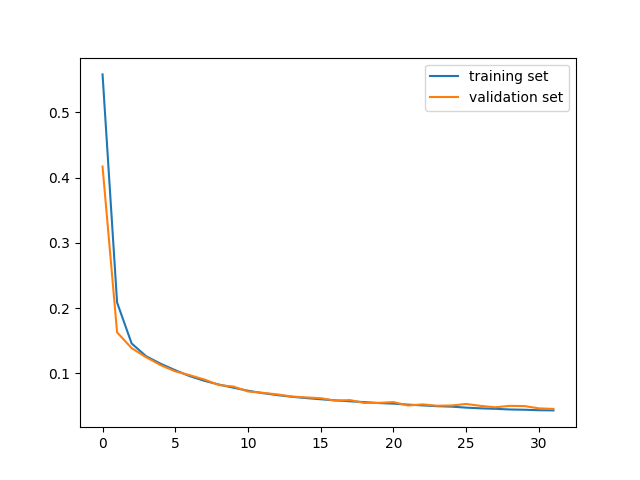

In [18]:
# Plot the loss
plt.figure()
plt.plot(estimator.train_losses, label='training set')
plt.plot(estimator.valid_losses, label='validation set')
plt.legend(loc=0);

## Evaluate on the test set

In [25]:
# Compute test set predictions
estimator.model.eval()
test_preds = estimator.model(test_inputs)

# Compute test set accuracy
matches = (torch_to_np(test_preds) > 0.5) == (torch_to_np(test_y) > 0.5)
print('Test set accuracy:', matches.mean())

Test set accuracy: 0.978181112976


<IPython.core.display.Javascript object>


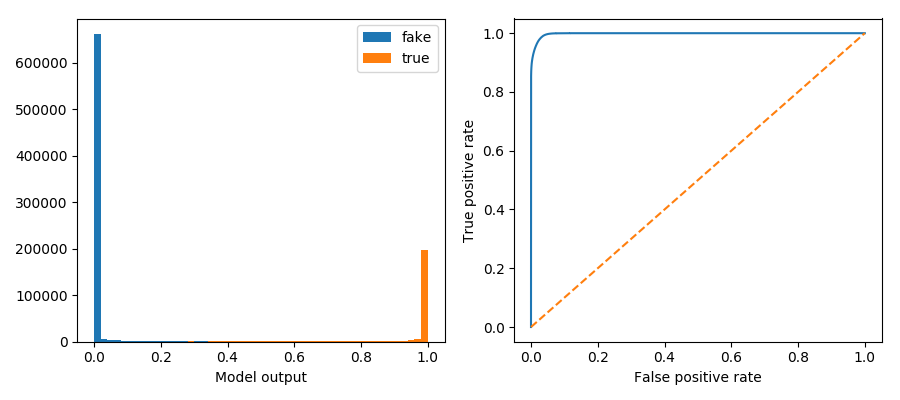

In [22]:
# Compute the ROC curve
_y = torch_to_np(test_y).flatten()
_preds = torch_to_np(test_preds).flatten()
fpr, tpr, _ = sklearn.metrics.roc_curve(_y, _preds)

plt.figure(figsize=(9,4))

# Plot the model outputs
plt.subplot(121)
binning=dict(bins=50, range=(0,1), histtype='bar')
plt.hist(_preds[_y<0.5], label='fake', **binning)
plt.hist(_preds[_y>0.5], label='true', **binning)
plt.xlabel('Model output')
plt.legend(loc=0)

# Plot the ROC curve
plt.subplot(122)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.tight_layout()

## Visualize model predictions on events

Let's draw events from the test set by coloring each segment according to the model prediction.
Segments with a score near zero should be invisible, whereas segments with a high score will be opaque.

<IPython.core.display.Javascript object>


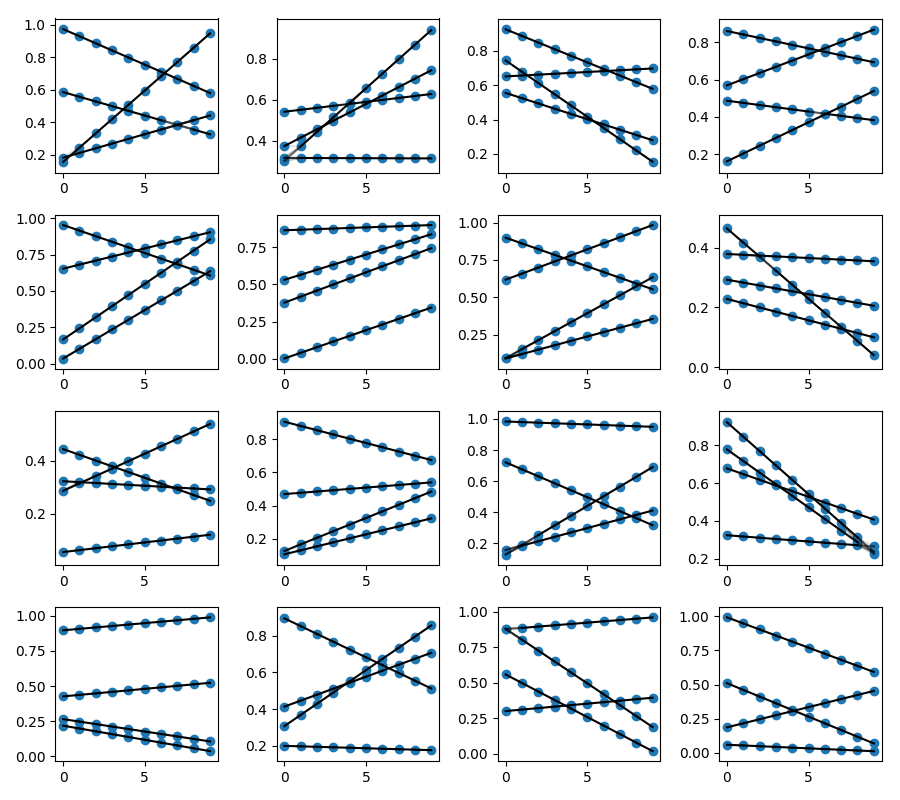

In [24]:
samples = range(16)

fig, axs = plt.subplots(4, 4, figsize=(9,8))
axs = axs.flatten()

# Loop over samples to draw
for i in samples:
    # Pull out the data for this sample
    sample_x, sample_r = torch_to_np(test_X[i,:,0]), torch_to_np(test_X[i,:,1])
    sample_pred = torch_to_np(test_preds[i])
    sample_Ri, sample_Ro = torch_to_np(test_Ri[i]), torch_to_np(test_Ro[i])

    # Start and end points of the segments
    idxo = np.where(sample_Ro.T>0.5)[1]
    idxi = np.where(sample_Ri.T>0.5)[1]
    r1 = sample_r[idxo]
    r2 = sample_r[idxi]
    x1 = sample_x[idxo]
    x2 = sample_x[idxi]

    # Draw all the hits
    axs[i].scatter(sample_r, sample_x)

    # Draw the segments
    for j in range(n_edges):
        axs[i].plot([r1[j], r2[j]], [x1[j], x2[j]], 'k-', alpha=sample_pred[j])

plt.tight_layout()

## Discussion

This model currently achieves 98% accuracy on the test set. From the ROC curve as well it is clear that it does very well at classifying both real and fake segments.

This result is already quite promising, but the approach needs to be tested on realistic tracking data (e.g. ACTS).